<a href="https://colab.research.google.com/github/sreesriavvaru123/MI/blob/main/MI_CNN_LSTM_v11_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Colab-compatible notebook for MI detection using PTB-XL with 12-leads and 10-fold CV



## STEP 1: Install necessary packages



In [1]:
!pip install wfdb scikit-learn matplotlib tensorflow --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 113.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.0 which is incompatible.
cudf-cu12 25.2.1 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.0 which is incompatible.
dask-cudf-cu12 25.2.2 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.0 which is incompatible.


In [2]:
!pip install tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 11.4 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.4
    Uninstalling typeguard-4.4.4:
      Successfully uninstalled typeguard-4.4.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


## STEP 2: Import required libraries


In [3]:
# CNN-LSTM with Stacking Decoding on PTB-XL (MI, Healthy, Other) - 12-lead Version
# Step 2: Imports
import os
import numpy as np
import pandas as pd
import wfdb
from tqdm import tqdm
from scipy.signal import savgol_filter, resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, BatchNormalization, Dropout, LSTM, Dense
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.callbacks import EarlyStopping

## STEP 3: Download and unzip PTB-XL data

In [4]:
from google.colab import files
files.upload()  # Upload kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Install kaggle CLI if not already
!pip install -q kaggle

# Download the PTB-XL dataset
!kaggle datasets download -d khyeh0719/ptb-xl-dataset

# Unzip the dataset
!unzip ptb-xl-dataset.zip -d ptb-xl


Streaming output truncated to the last 5000 lines.
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19338_hr.hea  
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19339_hr.dat  
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19339_hr.hea  
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19340_hr.dat  
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19340_hr.hea  
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19341_hr.dat  
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19341_hr.hea  
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/1934

## STEP 4: Load metadata and diagnostic class mapping

In [5]:
import pandas as pd

ptbxl_path = "/content/ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/"
print("Loading metadata...")

# Load metadata and SCP diagnostic info
df = pd.read_csv(ptbxl_path + 'ptbxl_database.csv')
class_map = pd.read_csv(ptbxl_path + 'scp_statements.csv', index_col=0)

# Add full path to 100Hz signal files
df['filename_lr'] = ptbxl_path + df['filename_lr']

# Evaluate stringified dict to real dict
df['scp_codes'] = df['scp_codes'].apply(eval)

# Define mapping from SCP codes to 3 classes
def map_3_classes(scp_codes, class_map):
    """
    Maps SCP codes to 3 classes: MI, NORM, OTHER.
    """
    mi_codes = class_map[class_map['diagnostic_class'] == 'MI'].index.tolist()
    norm_codes = class_map[class_map['diagnostic_class'] == 'NORM'].index.tolist()

    for code in scp_codes.keys():
        if code in mi_codes:
            return 'MI'
        if code in norm_codes:
            return 'NORM'

    # If no MI or NORM code is found, return 'OTHER'
    return 'OTHER'

# Apply 3-class mapping
df['class'] = df['scp_codes'].apply(lambda x: map_3_classes(x, class_map))

# Drop rows with unmapped class
df = df[df['class'].notnull()]

# Display class distribution
print("Class distribution:")
print(df['class'].value_counts())

# Final usable dataset
df_multiclass = df[['filename_lr', 'class']]

Loading metadata...
Class distribution:
class
NORM     9528
OTHER    6824
MI       5485
Name: count, dtype: int64


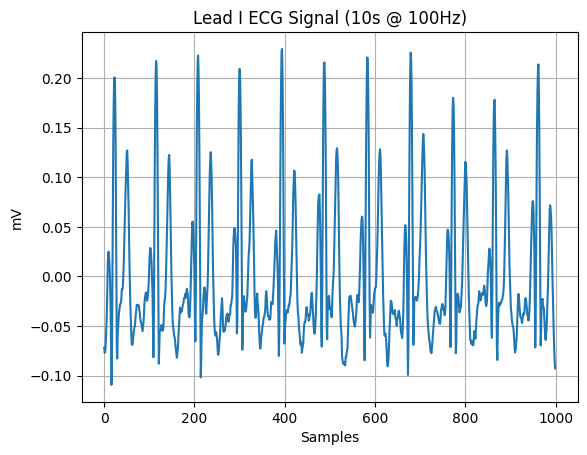

In [6]:
# Step 4: Signal Processing Function

def preprocess_ecg(record_path):
    record = wfdb.rdrecord(record_path)
    signal = record.p_signal.T  # Shape (12, 5000)

    # Denoising (per lead)
    signal_denoised = savgol_filter(signal, window_length=13, polyorder=3, axis=1)
    baseline = savgol_filter(signal_denoised, window_length=301, polyorder=4, axis=1)
    signal_clean = signal_denoised - baseline

    # Downsample from 500Hz to 250Hz
    # signal_downsampled = resample(signal_clean, 1000, axis=1)  # Direct to fixed 250Hz * 10s = 2500 samples
    return signal_clean

import matplotlib.pyplot as plt

test_ecg = preprocess_ecg(df_multiclass['filename_lr'].values[0].replace('.hea', ''))
plt.plot(test_ecg[0])  # Plot lead I
plt.title("Lead I ECG Signal (10s @ 100Hz)")
plt.xlabel("Samples")
plt.ylabel("mV")
plt.grid(True)
plt.show()

# Step 5: Create Dataset

def create_dataset(df, max_per_class=None):
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle
    X, y = [], []
    counts = {"MI": 0, "NORM": 0, "OTHER": 0}
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        label = row["class"]
        if max_per_class and counts[label] >= max_per_class:
            continue
        path = row["filename_lr"].replace(".hea", "")  # Remove .hea extension
        try:
            ecg = preprocess_ecg(path)
            if ecg.shape != (12, 1000):
                print(f"Skipping {path} due to incorrect shape {ecg.shape}")
                continue
            X.append(ecg)
            y.append(["MI", "NORM", "OTHER"].index(label))
            counts[label] += 1
        except Exception as e:
            print(f"Error processing {path}: {e}")
            continue
    print("Final class counts:", counts)
    X = np.array(X)
    y = to_categorical(y, num_classes=3)
    print("X shape:", X.shape)
    print("y shape:", y.shape)
    return X, y


In [7]:
# Unbalanced
print("Creating unbalanced dataset...")
X_unbal, y_unbal = create_dataset(df_multiclass)

# Balanced
print("Creating balanced dataset...")
X_bal, y_bal = create_dataset(df_multiclass, max_per_class=5000)

Creating unbalanced dataset...


100%|██████████| 21837/21837 [03:18<00:00, 110.01it/s]


Final class counts: {'MI': 5485, 'NORM': 9528, 'OTHER': 6824}
X shape: (21837, 12, 1000)
y shape: (21837, 3)
Creating balanced dataset...


100%|██████████| 21837/21837 [02:30<00:00, 144.97it/s] 


Final class counts: {'MI': 5000, 'NORM': 5000, 'OTHER': 5000}
X shape: (15000, 12, 1000)
y shape: (15000, 3)


In [8]:
# First: Train+Val (80%) and Test (20%)
# Step 7: Split 60/20/20
X = np.transpose(X_bal, (0, 2, 1))
y = y_bal
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y.argmax(axis=1), random_state=42)

# Then: Train (60%) and Val (20%)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp.argmax(axis=1), random_state=42)

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)


Train shape: (9000, 1000, 12)
Validation shape: (3000, 1000, 12)
Test shape: (3000, 1000, 12)


In [9]:
print(y_train)
y_train_3classes = df['class']
print(y_train_3classes)

[[0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]
0         NORM
1         NORM
2         NORM
3         NORM
4         NORM
         ...  
21832    OTHER
21833     NORM
21834    OTHER
21835     NORM
21836     NORM
Name: class, Length: 21837, dtype: object


In [14]:
# === CNN-LSTM BINARY CLASSIFIER ===
def create_binary_model():
    input_layer = Input(shape=(1000, 12))  # 12-lead ECG, 1000 samples
    x = Conv1D(32, 5, activation='relu', padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2)(x)
    x = Dropout(0.5)(x)

    x = Conv1D(32, 5, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2)(x)
    x = Dropout(0.5)(x)

    x = LSTM(64, return_sequences=True)(x)
    x = LSTM(64)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# === META CLASSIFIER ===
def create_meta_model(num_classes=3):
    model = Sequential([
        Dense(64, activation='tanh', input_shape=(6,)),
        Dense(32, activation='tanh'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer='rmsprop',
        loss='categorical_crossentropy',  # ✅ use this for one-hot
        metrics=['accuracy']
    )
    return model

def prepare_binary_dataset(X, y, class_a, class_b):
    idx = np.where((y == class_a) | (y == class_b))[0]
    X_bin = X[idx]
    y_bin = y[idx]
    y_bin = np.where(y_bin == class_a, 0, 1)  # class_a → 0, class_b → 1
    y_bin = to_categorical(y_bin, 2)
    return X_bin, y_bin

def get_meta_features(models, X):
    features = [model.predict(X, verbose=0) for model in models]
    return np.concatenate(features, axis=1)  # shape: (samples, 6)

model = create_meta_model(num_classes=3)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,627 (10.26 KB)

 Trainable params: 2,627 (10.26 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
def prepare_binary_dataset(X, y_onehot, class_a, class_b):
    """
    Extracts a binary dataset from the full one-hot encoded dataset.

    Parameters:
        X: Input samples, shape (N, 1000, 12)
        y_onehot: One-hot labels, shape (N, 3)
        class_a, class_b: The two class indices to compare (e.g., 0 and 2)

    Returns:
        X_binary: Filtered inputs for the 2 classes
        y_binary: One-hot encoded binary labels (N, 2)
    """
    # Convert one-hot → class index (e.g., 0, 1, 2)
    y_class = np.argmax(y_onehot, axis=1)

    # Get only samples of class_a or class_b
    idx = np.where((y_class == class_a) | (y_class == class_b))[0]
    X_bin = X[idx]
    y_bin = y_class[idx]

    # Relabel: class_a → 0, class_b → 1
    y_bin = np.where(y_bin == class_a, 0, 1)

    # Convert to binary one-hot encoding
    y_bin = to_categorical(y_bin, 2)

    return X_bin, y_bin


In [12]:
# Train Binary Classifiers
# Binary 1: AFIB (0) vs OTHER (2)
X1, y1 = prepare_binary_dataset(X_train, y_train, 0, 2)
model1 = create_binary_model()
model1.fit(X1, y1, epochs=20, batch_size=32, validation_split=0.2)

# Binary 2: NORM (1) vs OTHER (2)
X2, y2 = prepare_binary_dataset(X_train, y_train, 1, 2)
model2 = create_binary_model()
model2.fit(X2, y2, epochs=20, batch_size=32, validation_split=0.2)

# Binary 3: AFIB (0) vs NORM (1)
X3, y3 = prepare_binary_dataset(X_train, y_train, 0, 1)
model3 = create_binary_model()
model3.fit(X3, y3, epochs=20, batch_size=32, validation_split=0.2)


Epoch 1/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.5645 - loss: 0.6804 - val_accuracy: 0.5725 - val_loss: 0.7065
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.6571 - loss: 0.6383 - val_accuracy: 0.6000 - val_loss: 0.7122
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6767 - loss: 0.6167 - val_accuracy: 0.6508 - val_loss: 0.6627
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.7022 - loss: 0.5965 - val_accuracy: 0.6908 - val_loss: 0.6241
Epoch 5/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7016 - loss: 0.6027 - val_accuracy: 0.7175 - val_loss: 0.5990
Epoch 6/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7104 - loss: 0.5820 - val_accuracy: 0.6783 - val_loss: 0.6116
Epoch 7/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7083 - loss: 0.5900 - val_accuracy: 0.7192 - val_loss: 0.5753
Epoch 8/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7217 - loss: 0.5783 - val_acc

In [15]:
# 7. Train Meta-Classifier on Full 3-Class Data
X_meta_train = get_meta_features([model1, model2, model3], X_train)
y_meta_train = y_train  # integer encoded (0, 1, 2)

meta_model = create_meta_model(num_classes=3)
history = meta_model.fit(X_meta_train, y_meta_train, epochs=30, batch_size=32, validation_split=0.2)


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7152 - loss: 0.7052 - val_accuracy: 0.7139 - val_loss: 0.6955
Epoch 2/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7435 - loss: 0.6248 - val_accuracy: 0.7133 - val_loss: 0.6932
Epoch 3/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7400 - loss: 0.6358 - val_accuracy: 0.7128 - val_loss: 0.6966
Epoch 4/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7447 - loss: 0.6207 - val_accuracy: 0.7122 - val_loss: 0.6978
Epoch 5/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7509 - loss: 0.6244 - val_accuracy: 0.7161 - val_loss: 0.6965
Epoch 6/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7418 - loss: 0.6285 - val_accuracy: 0.7089 - val_loss: 0.7038
Epoch 7/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7422 - loss: 0.6263 - val_accuracy: 0.7122 - val_loss: 0.6998
Epoch 8/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7507 - loss: 0.6257 - val_accuracy: 0.7128 - val

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Test Accuracy: 0.7276666666666667
              precision    recall  f1-score   support

        AFIB       0.72      0.69      0.70      1000
        NORM       0.76      0.86      0.81      1000
       OTHER       0.69      0.63      0.66      1000

    accuracy                           0.73      3000
   macro avg       0.72      0.73      0.72      3000
weighted avg       0.72      0.73      0.72      3000



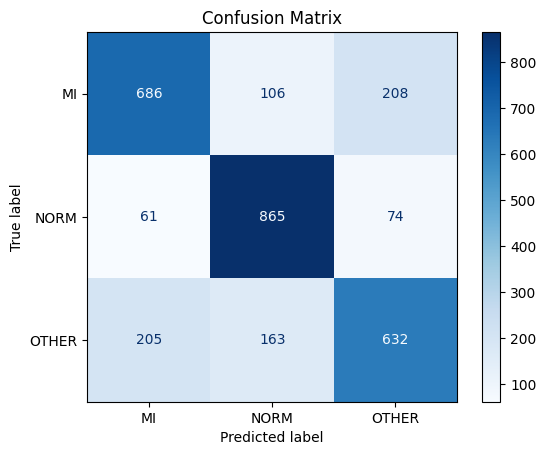

NameError: name 'history' is not defined

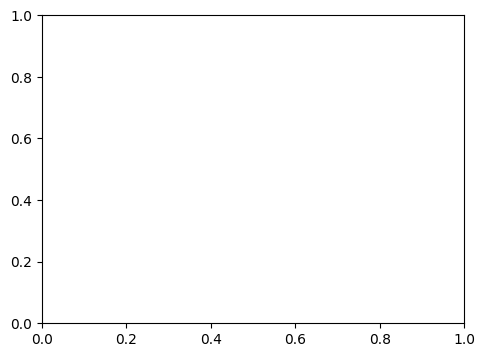

In [19]:
from sklearn.metrics import accuracy_score, classification_report
# Get predictions
y_pred_meta = np.argmax(meta_model.predict(X_meta_test), axis=1)
y_true = np.argmax(y_test, axis=1)  # Only if y_test is one-hot

# Print evaluation
print("Test Accuracy:", accuracy_score(y_true, y_pred_meta))
print(classification_report(y_true, y_pred_meta, target_names=["AFIB", "NORM", "OTHER"]))

# Step 12: Confusion Matrix
cm = confusion_matrix(y_true, y_pred_meta)
ConfusionMatrixDisplay(cm, display_labels=["MI", "NORM", "OTHER"]).plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Step 13: Training Curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
Classification Report:
              precision    recall  f1-score   support

          MI       0.77      0.75      0.76      1000
        NORM       0.73      0.91      0.81      1000
       OTHER       0.76      0.60      0.67      1000

    accuracy                           0.75      3000
   macro avg       0.76      0.75      0.75      3000
weighted avg       0.76      0.75      0.75      3000



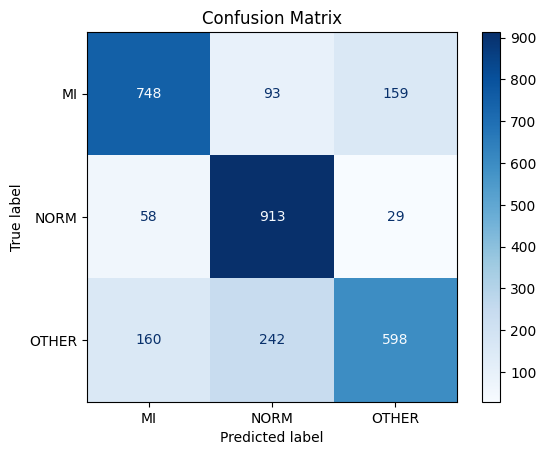

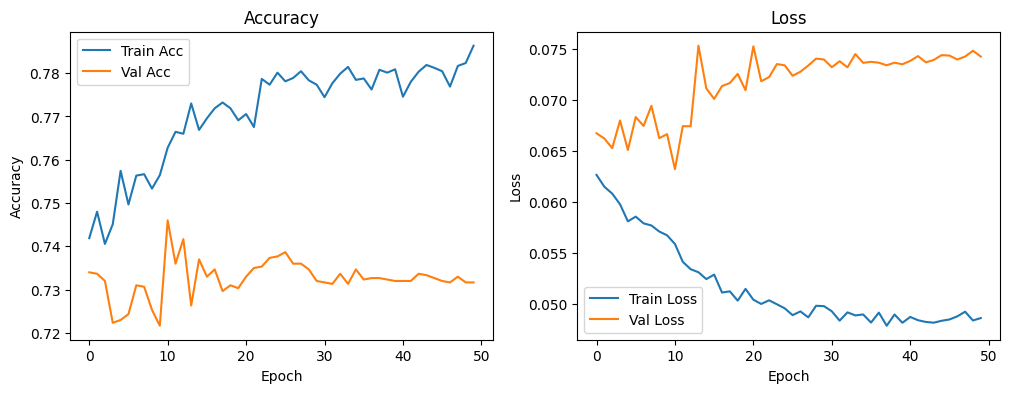

In [31]:
# Step 11: Classification Report
pred = model.predict(X_test)
y_pred = np.argmax(pred, axis=1)
y_true = np.argmax(y_test, axis=1)
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["MI", "NORM", "OTHER"]))

# Step 12: Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=["MI", "NORM", "OTHER"]).plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Step 13: Training Curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()
